# *Importing Libraries:*

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.legacy import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# *Preprocessing:*


In [2]:
path = 'Multi-class Weather Dataset/'
folders = os.listdir(path)
print(folders)

['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,)

train_generator = datagen.flow_from_directory(
    path,
    target_size=(250,250),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    path,
    target_size=(250,250),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='validation')

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


### Show sample:

In [4]:
classes = list(train_generator.class_indices.keys())
img, lable = train_generator.next()
img.shape

(32, 250, 250, 3)

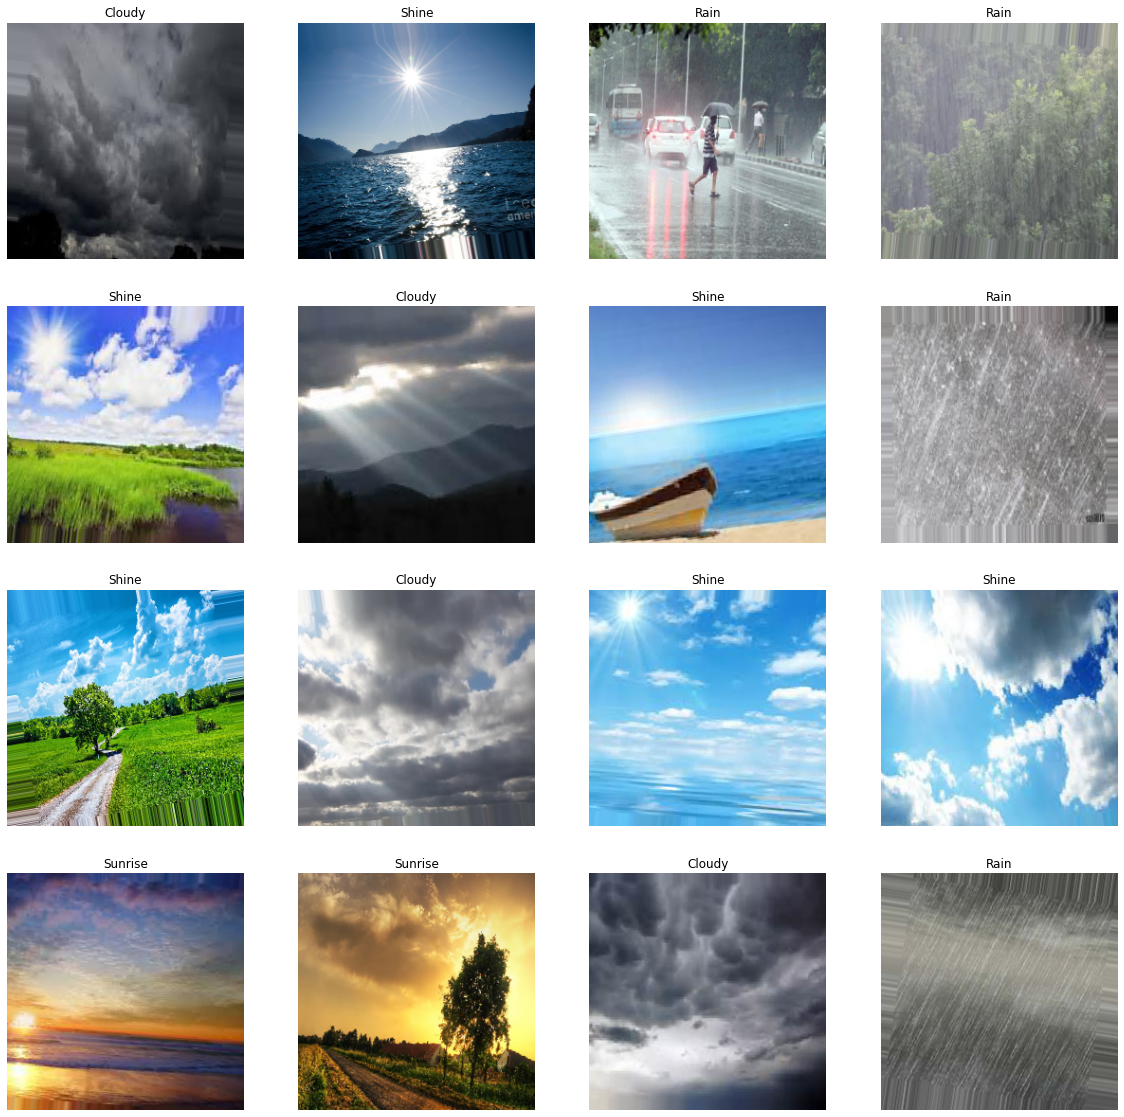

In [5]:
plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i])
    index = np.argmax(lable[i]) 
    class_name = classes[index]
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [48]:
def draw_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].set_title('Training & validation accuracy', fontsize = 15, fontweight = 'bold')
    axis[0].plot(acc, label='training accuracy', color='darkblue')
    axis[0].plot(val_acc, label='validation accuracy', color='deeppink')
    axis[0].legend()
    axis[1].set_title('Training & validation loss', fontsize = 15, fontweight = 'bold')
    axis[1].plot(loss, label='training loss', color='darkblue')
    axis[1].plot(val_loss, label='validation loss', color='deeppink')
    axis[1].legend()
    
    print("Maximum Accuracy of Training set: {:.8f}\nMinimum Loss of Trainig set: {:.8f}\n".format(np.max(acc), np.min(loss)))
    print("Maximum Accuracy of Validation set: {:.8f}\nMinimum Loss of Validation set: {:.8f}\n".format(np.max(val_acc), np.min(val_loss))) 

def draw_plot_fine(history, history_ft):
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc += history_ft.history['accuracy']
    val_acc += history_ft.history['val_accuracy']

    loss += history_ft.history['loss']
    val_loss += history_ft.history['val_loss']

    plt.figure(figsize=(14, 12))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy', color='darkblue')
    plt.plot(val_acc, label='Validation Accuracy', color='deeppink')
    plt.ylim([0.7, 1])
    plt.xlim([-1, EPOCHS + 11])
    plt.plot([EPOCHS, EPOCHS], plt.ylim(), label='Start Fine Tuning', color='g')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss', color='darkblue')
    plt.plot(val_loss, label='Validation Loss', color='deeppink')
    plt.ylim([0, 1.0])
    plt.xlim([-1, EPOCHS + 11])
    plt.plot([EPOCHS, EPOCHS], plt.ylim(), label='Start Fine Tuning', color='g')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    
def print_confusion_matrix(y, y_pred):
    cm = confusion_matrix(y.classes, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Cloudy', 'Rain', 'Shine', 'Sunrise'])
    cmd.plot()
    plt.xlabel('Predicted Values', fontsize = 12)
    plt.ylabel('Actual Values', fontsize = 12)
    plt.show()

# *Model Structure:*

In [7]:
# global parameters:
EPOCHS = 20
IMG_SHAPE = (250, 250, 3)
LR = 1e-3
OPTIMIZER = Adamax(LR)
LOSS = CategoricalCrossentropy()
METRICS = ['accuracy']

## Dense Neural Network:

In [8]:
model_dnn = Sequential([
    Input(shape=(250, 250, 3)),
    Flatten(),
    
    Dense(128, 'relu'),
    BatchNormalization(),
    
    Dense(64, 'relu'),
    BatchNormalization(),
    
    Dense(32, 'relu'),
    BatchNormalization(),
    
    Dense(16, 'relu'),
    BatchNormalization(),
    
    Dense(8, 'relu'),
    BatchNormalization(),
    
    Dense(4, 'softmax')
])

model_dnn.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [9]:
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 187500)            0         
                                                                 
 dense (Dense)               (None, 128)               24000128  
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [10]:
hist_dnn = model_dnn.fit(train_generator, validation_data = validation_generator, epochs = 10, verbose = 2)

Epoch 1/10
29/29 - 18s - loss: 1.2111 - accuracy: 0.4595 - val_loss: 1.7008 - val_accuracy: 0.2723 - 18s/epoch - 617ms/step
Epoch 2/10
29/29 - 16s - loss: 0.9630 - accuracy: 0.6093 - val_loss: 1.4213 - val_accuracy: 0.2277 - 16s/epoch - 550ms/step
Epoch 3/10
29/29 - 16s - loss: 0.8527 - accuracy: 0.6582 - val_loss: 1.2351 - val_accuracy: 0.4286 - 16s/epoch - 547ms/step
Epoch 4/10
29/29 - 17s - loss: 0.7438 - accuracy: 0.7381 - val_loss: 1.0620 - val_accuracy: 0.5491 - 17s/epoch - 594ms/step
Epoch 5/10
29/29 - 17s - loss: 0.6909 - accuracy: 0.7691 - val_loss: 1.0163 - val_accuracy: 0.5580 - 17s/epoch - 600ms/step
Epoch 6/10
29/29 - 18s - loss: 0.6384 - accuracy: 0.7891 - val_loss: 0.8757 - val_accuracy: 0.6741 - 18s/epoch - 624ms/step
Epoch 7/10
29/29 - 18s - loss: 0.5791 - accuracy: 0.8091 - val_loss: 0.8649 - val_accuracy: 0.6473 - 18s/epoch - 614ms/step
Epoch 8/10
29/29 - 17s - loss: 0.5994 - accuracy: 0.7913 - val_loss: 0.8158 - val_accuracy: 0.7009 - 17s/epoch - 600ms/step
Epoch 9/

# *Convolutional Neural Network:*
### *Using Transfer Learning...*


## VGG16:

In [10]:
base_model = tf.keras.applications.VGG16(include_top=False, 
                                         weights='imagenet', 
                                         input_shape=IMG_SHAPE)

In [11]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [12]:
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [13]:
model_cnn = Sequential([
    base_model,
    MaxPooling2D(),
    Flatten(),
    Dense(256, 'relu'),
    BatchNormalization(),
    Dense(64, 'relu'),
    BatchNormalization(),
    Dense(len(classes), "softmax")
])

model_cnn.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [14]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               1179904   
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 64)               

In [15]:
len(model_cnn.trainable_variables)

12

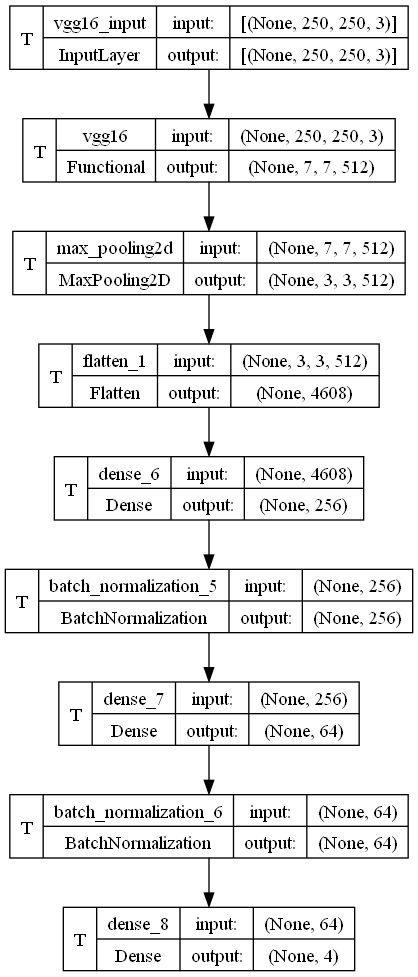

In [16]:
plot_model(model_cnn, show_shapes = True, show_trainable = True)

In [17]:
hist_cnn = model_cnn.fit(train_generator, validation_data = validation_generator, epochs = EPOCHS, verbose = 2)

Epoch 1/20
29/29 - 145s - loss: 0.4782 - accuracy: 0.8368 - val_loss: 3.0613 - val_accuracy: 0.3170 - 145s/epoch - 5s/step
Epoch 2/20
29/29 - 167s - loss: 0.2011 - accuracy: 0.9334 - val_loss: 2.9002 - val_accuracy: 0.3661 - 167s/epoch - 6s/step
Epoch 3/20
29/29 - 167s - loss: 0.1275 - accuracy: 0.9645 - val_loss: 1.1284 - val_accuracy: 0.6027 - 167s/epoch - 6s/step
Epoch 4/20
29/29 - 167s - loss: 0.0768 - accuracy: 0.9811 - val_loss: 1.9154 - val_accuracy: 0.4821 - 167s/epoch - 6s/step
Epoch 5/20
29/29 - 168s - loss: 0.0610 - accuracy: 0.9900 - val_loss: 1.5629 - val_accuracy: 0.6116 - 168s/epoch - 6s/step
Epoch 6/20
29/29 - 167s - loss: 0.0462 - accuracy: 0.9922 - val_loss: 0.6151 - val_accuracy: 0.7768 - 167s/epoch - 6s/step
Epoch 7/20
29/29 - 167s - loss: 0.0465 - accuracy: 0.9878 - val_loss: 0.7579 - val_accuracy: 0.7589 - 167s/epoch - 6s/step
Epoch 8/20
29/29 - 167s - loss: 0.0473 - accuracy: 0.9889 - val_loss: 0.6338 - val_accuracy: 0.8036 - 167s/epoch - 6s/step
Epoch 9/20
29/29

Maximum Accuracy of Training set: 0.99889010
Minimum Loss of Trainig set: 0.01711808

Maximum Accuracy of Validation set: 0.93303573
Minimum Loss of Validation set: 0.20366685



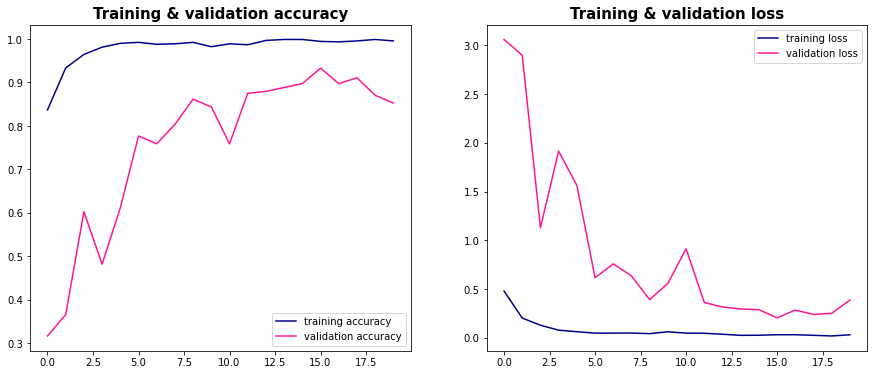

In [22]:
draw_plot(hist_cnn)

In [29]:
model_cnn.compile(optimizer = Adamax(LR / 10), loss = LOSS, metrics = METRICS)

In [30]:
total_epochs = EPOCHS + 10

hist_cnn_fine = model_cnn.fit(train_generator, 
                              validation_data = validation_generator, 
                              epochs = total_epochs, 
                              initial_epoch = hist_cnn.epoch[-1],
                              verbose = 2)

Epoch 20/30
29/29 - 170s - loss: 0.0300 - accuracy: 0.9933 - val_loss: 0.3639 - val_accuracy: 0.8661 - 170s/epoch - 6s/step
Epoch 21/30
29/29 - 169s - loss: 0.0254 - accuracy: 0.9956 - val_loss: 0.2579 - val_accuracy: 0.8795 - 169s/epoch - 6s/step
Epoch 22/30
29/29 - 168s - loss: 0.0171 - accuracy: 0.9978 - val_loss: 0.2838 - val_accuracy: 0.8929 - 168s/epoch - 6s/step
Epoch 23/30
29/29 - 171s - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.2548 - val_accuracy: 0.9018 - 171s/epoch - 6s/step
Epoch 24/30
29/29 - 174s - loss: 0.0144 - accuracy: 0.9989 - val_loss: 0.2528 - val_accuracy: 0.9062 - 174s/epoch - 6s/step
Epoch 25/30
29/29 - 177s - loss: 0.0139 - accuracy: 0.9989 - val_loss: 0.2677 - val_accuracy: 0.8973 - 177s/epoch - 6s/step
Epoch 26/30
29/29 - 171s - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.2581 - val_accuracy: 0.9107 - 171s/epoch - 6s/step
Epoch 27/30
29/29 - 170s - loss: 0.0174 - accuracy: 0.9967 - val_loss: 0.2802 - val_accuracy: 0.9018 - 170s/epoch - 6s/step
Epoch 28

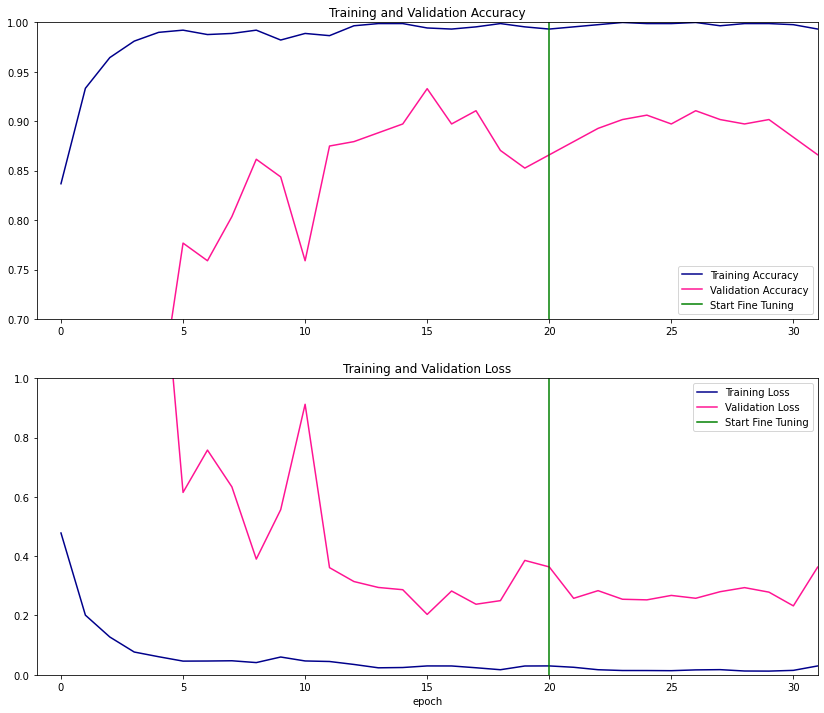

In [49]:
draw_plot_fine(hist_cnn, hist_cnn_fine)

## Evaluation

In [31]:
loss, accuracy = model_cnn.evaluate(validation_generator)
print('Test accuracy :', accuracy * 100)

7/7 [==============================] - 33s 5s/step - loss: 0.2726 - accuracy: 0.9107
Test accuracy : 91.07142686843872


## Get Predictions

In [32]:
preds = model_cnn.predict(validation_generator)
y_pred = np.argmax(preds, axis=1)

7/7 [==============================] - 33s 5s/step


## Confusion Matrics 

## Save Model

In [51]:
model_cnn.save('model_cnn.keras')